<a href="https://colab.research.google.com/github/Kevo1906/Food_Vision_Project/blob/main/Food_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Vision Project
In this project we're going to build a food image clasificator, traying to beat the results from the Food101 paper

**We've got the goal of beating [DeepFood](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment)**, a 2016 paper which used a Convolutional Neural Network trained for 2-3 days to achieve 77.4% top-1 accuracy.


## Confirm acces to a GPU

Since we're going to be building deep learning models with **mixed precision training**, let's make sure we have a GPU.

In [1]:
# Check for GPU

!nvidia-smi -L

/bin/bash: nvidia-smi: command not found


## Get helper functions
We've created a series of helper functions so we're going to import the`helper_functions.py` file from the GitHub repo.

In [2]:
# Get helper functions file
import os

if not os.path.exists("helper_functions.py"):
  !wget https://raw.githubusercontent.com/Kevo1906/Food_Vision_Project/main/helper_functions.py
else:
  print("[INFO] 'helper_functions_py already exists.")

--2023-05-31 01:45:20--  https://raw.githubusercontent.com/Kevo1906/Food_Vision_Project/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8937 (8.7K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   8.73K  --.-KB/s    in 0s      

2023-05-31 01:45:20 (87.6 MB/s) - ‘helper_functions.py’ saved [8937/8937]



In [3]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys
 

## Import the dataset using TensorFlow Datasets


In [4]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds
import tensorflow as tf

datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [5]:
# Load in the data 
from sklearn.utils import shuffle
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteR4OENK/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteR4OENK/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [6]:
# Features of Food101
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [7]:
# Getting the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Exploring the Food101 data

In [8]:
# Taking one sample off the training data
train_one_sample = train_data.take(1)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [9]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from (tensor form): {label}
  Class name: {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from (tensor form): 31
  Class name: donuts
  


In [10]:
# What does an image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[131,  86,  55],
        [134,  89,  58],
        [137,  92,  61],
        ...,
        [131,  44,   0],
        [135,  49,   2],
        [138,  52,   5]],

       [[134,  89,  58],
        [135,  90,  59],
        [135,  90,  59],
        ...,
        [133,  46,   1],
        [134,  48,   1],
        [134,  48,   1]],

       [[136,  91,  60],
        [137,  92,  61],
        [139,  94,  63],
        ...,
        [137,  53,   7],
        [135,  51,   5],
        [131,  47,   1]],

       ...,

       [[130,  23,   3],
        [134,  31,  14],
        [132,  36,  24],
        ...,
        [243, 248, 242],
        [243, 248, 242],
        [243, 248, 242]],

       [[128,  22,   0],
        [129,  26,   7],
        [124,  28,  14],
        ...,
        [243, 248, 241],
        [242, 247, 240],
        [242, 247, 240]],

       [[132,  26,   2],
        [133,  31,   9],
        [126,  29,  13],
        ...,
        [242, 247, 24

In [11]:
# What are the min and max values of our image tensor
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

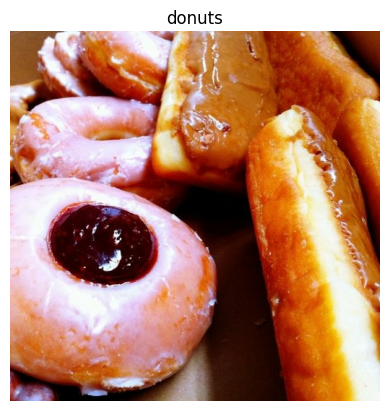

In [12]:
# Plot an image from the dataset
import matplotlib.pyplot as plt

plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Create preprocessing functions for our data

In [13]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=384):
  """
  Converts image datatype from 'unit8' -> 'float32' and reshapes
  image to [img_shape, img_shape, color]
  """
  image = tf.image.resize(image, [img_shape, img_shape])
  image = tf.cast(image, tf.float32)
  image = image/255.0 
  return image, label

In [14]:
# Testing our function in a single sample
preprocessed_img = preprocess_img(image,label)[0]
print(f"Image before preprocessing: \n {image[:2]}...., \nShape: {image.shape}, \nDatatype: {image.dtype}")
print(f"Image after preprocessing: \n {preprocessed_img[:2]}...., \nShape: {preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}")

Image before preprocessing: 
 [[[131  86  55]
  [134  89  58]
  [137  92  61]
  ...
  [131  44   0]
  [135  49   2]
  [138  52   5]]

 [[134  89  58]
  [135  90  59]
  [135  90  59]
  ...
  [133  46   1]
  [134  48   1]
  [134  48   1]]]...., 
Shape: (512, 512, 3), 
Datatype: <dtype: 'uint8'>
Image after preprocessing: 
 [[[5.1742917e-01 3.4095860e-01 2.1938999e-01]
  [5.3104579e-01 3.5457516e-01 2.3300654e-01]
  [5.3867096e-01 3.6220044e-01 2.4063180e-01]
  ...
  [5.1122010e-01 1.7004366e-01 1.0894577e-04]
  [5.2189541e-01 1.8267973e-01 3.9215689e-03]
  [5.3692818e-01 1.9967330e-01 1.5359577e-02]]

 [[5.3006536e-01 3.5359475e-01 2.3202614e-01]
  [5.3529412e-01 3.5882354e-01 2.3725490e-01]
  [5.4052293e-01 3.6405227e-01 2.4248366e-01]
  ...
  [5.1960808e-01 1.8431397e-01 7.5165392e-03]
  [5.2843136e-01 1.9411765e-01 1.3725490e-02]
  [5.2091497e-01 1.8758161e-01 5.2286782e-03]]]...., 
Shape: (384, 384, 3), 
Datatype: <dtype: 'float32'>


(-0.5, 383.5, 383.5, -0.5)

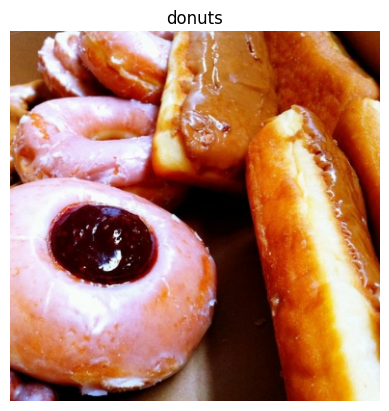

In [16]:
# Ploting our preprocessed image
plt.imshow(preprocessed_img)
plt.title(class_names[label])
plt.axis(False)

## Batch and prepare datasets


In [17]:
# Map preprocessing function to training data (and paralellize) 
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE) # for process large amount of data using all the processors that are availible
# Shuffle train_data and turn it into batches and prefetch
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [18]:
# Check out what our prepared datasets look like
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 384, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 384, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modelling callbacks
Since we're going to be training on a large amount of data and training could take a long time, it's a good idea to set up some modelling callbacks so we be sure of things like our model's training logs being tracked and our model being checkpointed (saved) after various training milestones.

To do each of these we'll use the following callbacks:
* `tf.keras.callbacks.TensorBoard()`.- Allows us to keep track of our model's training history so we can inspect it later 
* `tf.keras.callbacks.ModelCheckpoint()`.- Saves our model's progress at various intervals so we can load it and resuse it later without having to retrain it
  

In [19]:
# Create TensorBoard callback using a function from helper functions
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress
checkpoint_path = 'model_chekpoints/cp.ckpt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                  patience=3) 

## Setup mixed precision training

In [20]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("float32")

In [21]:
mixed_precision.global_policy()

<Policy "float32">

## Building feature extraction model
Because our dataset is quite large, we're going to move towards fine-tuning an existing pretrained model (EfficienetNetB4).

In [22]:
from keras.engine.sequential import training
from tensorflow.keras import layers
import tensorflow_hub as hub
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (None,None,3)
base_model = hub.KerasLayer("https://tfhub.dev/google/bit/m-r50x1/1",
                       trainable=False,
                       name="efficientnet_v2")

# Create functional model

inputs = layers.Input(shape=input_shape, dtype=tf.float32,name='input_layer')
# Another model different of EfficientNet needs rescaling the data for work
# x = preprocessing.Rescaling(1./255.0)(x)
x = base_model(inputs, training= False)
# x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x)
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model 
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [23]:
# Check out our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, None, None, 3)]   0         
                                                                 
 efficientnet_v2 (KerasLayer  (None, 2048)             23500352  
 )                                                               
                                                                 
 dense (Dense)               (None, 101)               206949    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 23,707,301
Trainable params: 206,949
Non-trainable params: 23,500,352
_________________________________________________________________


## Checking layer dtype policies (are we using mixed precision?)
We're going to check this by iterating through our model's layers and printing layer attributes such as `dtype` and `dtype_policy`


In [24]:
# Looking for the data type in each layer of the model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnet_v2 False float32 <Policy "float32">
dense True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">


In [25]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

AttributeError: ignored

## Fit the feature extraction model

In [ ]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the featrue extraction model
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=100,
                                                     steps_per_epoch=(len(train_data)),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks= [create_tensorboard_callback(dir_name="training_logs",
                                                                                             experiment_name="efficientnetb0_101_feature_extract"),
                                                                 model_checkpoint,
                                                                 early_stopping])


Saving TensorBoard log files to: training_logs/efficientnetb0_101_feature_extract/20230531-020332
Epoch 1/100
 240/2368 [==>...........................] - ETA: 16:18:38 - loss: 3.1000 - accuracy: 0.4315

In [39]:
# Evaluate model on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 66s 83ms/step - loss: 1.0945 - accuracy: 0.7038


[1.0944874286651611, 0.7037623524665833]

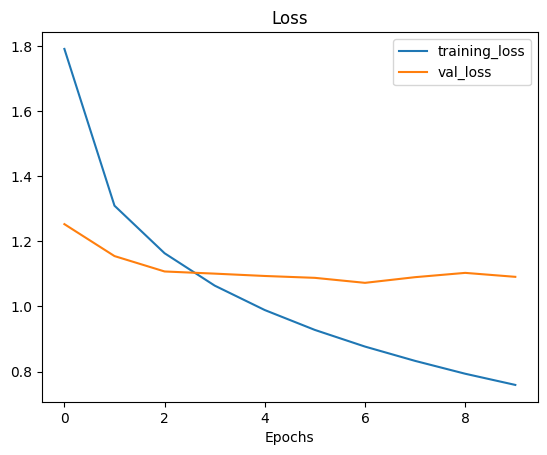

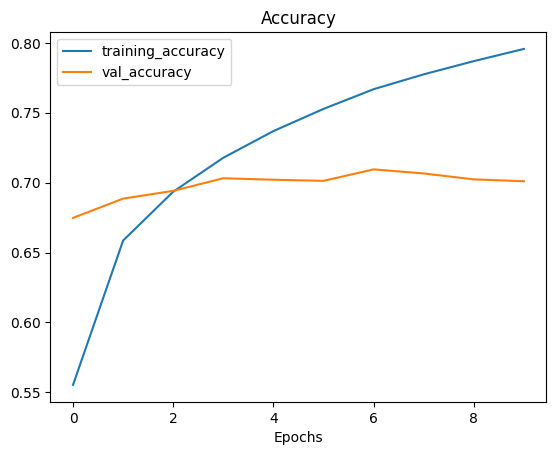

In [40]:
# Plot loss and accuracy curves with a helper function
plot_loss_curves(history_101_food_classes_feature_extract)

## Save model

In [42]:
# Create save path to drive 
save_dir = "drive/MyDrive/food_vision/feature_extract_model/"
# os.makedirs(save_dir)

# Save model
model.save(save_dir)

TypeError: ignored

## Preparing our model's layers for fine-tuning 
Our feature-extraction model is showing some great promise after three epochs. But since we've got so much data, it's probably worthwhile that we see what results we can get with fine-tuning.

Remember our goal of beating the [DeepFood paper](https://arxiv.org/pdf/1606.05675.pdf)?

They were able to achieve 77.4% top-1 accuracy on Food101 over 2-3 days of training.

In [43]:
# Are any of the layers in our model frozen?
for layer in model.layers:
  layer.trainable = True 
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb4 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_2 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


We're going to start with the first 20 layers of the base model

In [44]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[-20:]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

block7a_project_conv True float32 <Policy "mixed_float16">
block7a_project_bn True float32 <Policy "mixed_float16">
block7b_expand_conv True float32 <Policy "mixed_float16">
block7b_expand_bn True float32 <Policy "mixed_float16">
block7b_expand_activation True float32 <Policy "mixed_float16">
block7b_dwconv True float32 <Policy "mixed_float16">
block7b_bn True float32 <Policy "mixed_float16">
block7b_activation True float32 <Policy "mixed_float16">
block7b_se_squeeze True float32 <Policy "mixed_float16">
block7b_se_reshape True float32 <Policy "mixed_float16">
block7b_se_reduce True float32 <Policy "mixed_float16">
block7b_se_expand True float32 <Policy "mixed_float16">
block7b_se_excite True float32 <Policy "mixed_float16">
block7b_project_conv True float32 <Policy "mixed_float16">
block7b_project_bn True float32 <Policy "mixed_float16">
block7b_drop True float32 <Policy "mixed_float16">
block7b_add True float32 <Policy "mixed_float16">
top_conv True float32 <Policy "mixed_float16">
t

## A couple more callbacks
We're about to start fine-tuning a deep learning model with over 200 layers using over 100,000 (75k+ training, 25K+ testing) images, which means our model's training time is probably going to be much longer than before.

Ideally, when your model stops improving. But again, due to the nature of deep learning, it can be hard to know when exactly a model will stop improving.

Luckily, there's a solution: the `ModelCheckpoint`, `EarlyStopping` callbacks and the `ReduceLROnPlateau` callback wich monitors a specified metric and when that metric stops improving, it reduces the learning rate by a specified factor (e.g. divides the learning rate by 10).

In [45]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                  patience=3) 

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [46]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [47]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune = model.fit(train_data,
                                                        epochs=100, 
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)),
                                                        initial_epoch=history_101_food_classes_feature_extract.epoch[-1],
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"),  
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20230530-232053
Epoch 10/100
2368/2368 [==============================] - ETA: 0s - loss: 0.7643 - accuracy: 0.7840

TypeError: ignored

In [ ]:
# Evaluate fine-tuned model on the whole test dataset
results_fine_tune_model = model.evaluate(test_data)
results_fine_tune_model

In [ ]:
compare_historys(original_history=history_101_food_classes_feature_extract,
                 new_history=history_101_food_classes_all_data_fine_tune,
                 initial_epochs=3)

## Making predictions with our trained model

In [ ]:
# Make predictions with the model
pred_probs = model.predict(test_data, verbose=1)

# Get the class predictions of each label
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

In [ ]:
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

## Evaluating our models predictions

In [ ]:
# Get accuracy score by comparing predicted classes vs truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Creating a confusion matrix function for our model
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
# Get the class names
class_names = test_data.class_names

# Plot a confusion matrix 
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

## Visualizing predictions on test images

In [ ]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
    # Load the image and make predictions
  img = random.choice(test_data) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

## Finding the most wrong predictions

In [ ]:
# Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()


In [ ]:
# Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

In [ ]:
# Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

In [ ]:
# Visualize some of the most wrong examples
images_to_view = 9
start_index = 0 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

## Test out the model on custom images of food

In [ ]:
# Define a function to prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

In [ ]:
# Make predictions on custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

## Saving our trained model


In [ ]:
model.save("101_food_classes_all_data_fine_tuned_model")